# Deep Markov Model

In [202]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np
import optuna
optuna.logging.disable_default_handler()

In [228]:
batch_size = 128#128
epochs = 70
seed = 1
torch.manual_seed(seed)

In [229]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [230]:
#計測モデルとか
def get_ot(st,lmap,max_range):
    dis = torch.sqrt((st[:,0]-lmap[0])**2+(st[:,1]-lmap[1])**2)
    angle = torch.atan2((lmap[1]-st[:,1]),(lmap[0]-st[:,0]))-st[:,2]
    return torch.stack([dis,torch.sin(angle),torch.cos(angle)],1)
    
def get_all_ot(st,lmap,max_range):
    measure = get_ot(st,lmap[0],max_range)
    for l in range(1,len(lmap)):
        measure = torch.cat([measure, get_ot(st,lmap[l],max_range)],1)
    return torch.tensor(measure)

In [231]:
landmark_num = 10
start_pos = [2.0,4.0,0.0,0.0]#x0,y0,yaw0

In [232]:
landmark_dim = 2
ot_dim = 3#[dis,rad_sin,rad_cos]
x_dim = landmark_num*ot_dim
h_dim = 32 #32
hidden_dim = 32 #32
z_dim = 4
u_dim = 3
t_max = 66

In [233]:
def normalize(data, *args):
    if len(args) == 0:
        max_data = torch.max(abs(data))
        data=data/max_data
    else :
        max_data=torch.max(abs(torch.tensor(args)))
        data=data/max_data
    return data

def ot_normal(ot,range_ot):
    ot=ot.view(len(ot),landmark_num,ot_dim)
    ot[:,:,0]=normalize(ot[:,:,0],range_ot[0][0],range_ot[0][1])
#     ot[:,:,1]=normalize(ot[:,:,1],range_ot[1][0],range_ot[1][1])#もともと-1:1
    ot = ot.view(len(ot),landmark_num*ot_dim)
    return ot

In [234]:
#データの読み込み
transform = transforms.Compose([transforms.ToTensor()])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

range_ot=torch.tensor([[0.0,150.0],[-np.pi*2,np.pi*2]])#otの[v,r]の最大と最小

#data loader #とりあえず1時系列分を分身させて食わせてる
#[time,s_x,s_y,s_yaw,uv,ur,ot[1],,,,ot[N]]
data = np.loadtxt('vehicle_motion_data.csv', delimiter=',')
data = torch.tensor([data],dtype=torch.float32)
st = data[0,:,1:(1+z_dim)]
ut = data[0,:,(1+z_dim):(1+z_dim+u_dim)]
ot = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
t_max=len(ot)
ot=ot_normal(ot,range_ot)

print(ot.size())
st=st.repeat(1000,1,1)
ut=ut.repeat(1000,1,1)
ot=ot.repeat(1000,1,1)
print(ot.size())


landmark = np.loadtxt('landmark_data.csv',delimiter=',')

train = torch.utils.data.TensorDataset(ot)
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(ot)
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

torch.Size([66, 30])
torch.Size([1000, 66, 30])


In [235]:
from pixyz.models import Model
from pixyz.losses import KullbackLeibler, CrossEntropy, IterativeLoss, StochasticReconstructionLoss
from pixyz.distributions import Bernoulli, Normal, Deterministic
from pixyz.utils import print_latex

In [236]:
class RNN(Deterministic):
    def __init__(self,h_dim):
        super(RNN, self).__init__(cond_var=["x"], var=["h"],name="q")
        self.rnn = nn.GRU(x_dim, h_dim, bidirectional=True)
#         self.h0 = torch.zeros(2, batch_size, self.rnn.hidden_size).to(device)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size

        
    def forward(self, x):
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
        h, _ = self.rnn(x, h0)
        return {"h": h}

In [237]:
class Generator(Normal):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"])
    
    def forward(self, z):#計測モデルそのまま
#         print("z.size",str(z.size()))
        zl=torch.cat([z[:,0:2],torch.atan2(z[:,2:3],z[:,3:4])],dim=1)
        ot=get_all_ot(zl,landmark,[1000,1000])
        ot=ot_normal(ot,range_ot) #データを正規化しなおしてる
        return {"loc": ot,"scale":torch.tensor(0.1).to(device)}

In [238]:
class Inference(Normal):
    def __init__(self,h_dim):
        super(Inference, self).__init__(cond_var=["h", "z_prev"], var=["z"], name="q")
        self.fc1 = nn.Linear(z_dim, h_dim*2)
        self.fc21 = nn.Linear(h_dim*2, z_dim)
        self.fc22 = nn.Linear(h_dim*2, z_dim)
        
    def forward(self, h, z_prev):
#         print("h.size",str(h.size()))
        h_z = torch.tanh(self.fc1(z_prev))
        h = 0.5 * (h + h_z)
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [239]:
class Prior(Normal):#通常ここには動作モデルをいれる
    def __init__(self,hidden_dim):
        super(Prior, self).__init__(cond_var=["z_prev"], var=["z"],name="p")
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, z_prev):
        h = F.relu(self.fc1(z_prev))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [240]:
# prior = Prior().to(device)
# encoder = Inference().to(device)
# decoder = Generator().to(device)
# rnn = RNN().to(device)

In [241]:
# print(prior)
# print("*"*80)
# print(encoder)
# print("*"*80)
# print(decoder)
# print("*"*80)
# print(rnn)

In [242]:
# generate_from_prior = prior * decoder
# full_encoder = rnn*encoder
# full_decoder = encoder*decoder
# print(generate_from_prior)
# print_latex(generate_from_prior)
# print(full_encoder)
# print_latex(full_encoder)

In [243]:
# step_loss = CrossEntropy(encoder,decoder) + KullbackLeibler(encoder, prior)
# # step_loss =  KullbackLeibler(encoder, prior)+StochasticReconstructionLoss(full_encoder,decoder)
# # step_loss = step_loss.mean()
# _loss = IterativeLoss(step_loss, max_iter=t_max, 
#                       series_var=["h","x"], update_value={"z": "z_prev"})
# # _loss2 = IterativeLoss(step_loss2, max_iter=t_max, 
# #                       series_var=["h","x"], update_value={"z": "z_prev","h":"h_prev"})
# # loss=_loss
# loss = _loss.expectation(rnn).mean()

# print_latex(step_loss)

In [244]:
# dmm = Model(loss, distributions=[rnn,encoder, decoder, prior], 
#             optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

In [245]:
# print(dmm)
# print_latex(dmm)

In [246]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for idx,[data] in enumerate(tqdm(loader)):#batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        batch_size = data.size()[0]
        x = data.transpose(0, 1) #多分転置してるだけ
        z_prev = torch.tensor(start_pos)
        z_prev = z_prev.repeat(batch_size, 1).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'z_prev': z_prev}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'z_prev': z_prev}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

In [247]:
def plot_image_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

In [248]:
import matplotlib.pyplot as plt
def plot_loss(epochs,history):
    plt.ylabel('$loss$', fontsize=16)
    plt.xlabel('$epoch$', fontsize=16)
    ay=plt.gca()
    plt.title("train_loss")
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
    plt.show()
    ay=plt.gca()
    plt.title("test_loss")
    plt.plot(range(epochs), [i+0.4 for i in history["test_loss"]])
    plt.show()

In [249]:
def inference_result(rnn,encoder):
    inference_net = rnn*encoder
    test_o = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
    test_o = torch.tensor(test_o).reshape(1,len(test_o),x_dim).to(device)
    z_prev = torch.tensor(start_pos).to(device)
    infered_result = inference_net.sample({"x":test_o,"z_prev":z_prev})["z"].to("cpu")
    infered_result=infered_result.numpy()

    plt.plot(infered_result[:,:, 0], infered_result[:,:, 1], "co")

    for i in range(len(infered_result[0])-1):
        plt.plot([infered_result[0][i][0],infered_result[0][i+1][0]],[infered_result[0][i][1],infered_result[0][i+1][1]],"r")

    plt.show()

In [250]:
def get_optimizer(trial):
  optimizer_names = ['Adam', 'MomentumSGD', 'RMSprop']
  optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

  if optimizer_name == optimizer_names[0]: 
    adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
    optimizer = optim.Adam
    optim_param = {"lr":adam_lr, "weight_decay":weight_decay}
  elif optimizer_name == optimizer_names[1]:
    momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.SGD
    optim_param = {"lr":momentum_sgd_lr, "momentum":0.9, "weight_decay":weight_decay}
  else:
    rms_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.RMSprop
    optim_param = {"lr":rms_lr}
  return optimizer,optim_param

In [251]:
def objective(trial):
    h_dim = trial.suggest_int('generator_units',10,100)
    prior_units = trial.suggest_int('generator_units',10,100)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    optimizer,optim_param = get_optimizer(trial)
    
    #part of model
    prior = Prior(prior_units).to(device)
    encoder = Inference(h_dim).to(device)
    decoder = Generator().to(device)
    rnn = RNN(h_dim).to(device)
    
    #LossFunction
    step_loss = CrossEntropy(encoder,decoder) + KullbackLeibler(encoder, prior)
    _loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["h","x"], update_value={"z": "z_prev"})
    loss = _loss.expectation(rnn).mean()
    
    #model
    dmm = Model(loss, distributions=[rnn,encoder, decoder, prior], 
            optimizer=optimizer, optimizer_params=optim_param, clip_grad_value=10)
    
    #その他
    writer = SummaryWriter()
    history = {"train_loss":[],"test_loss":[]}

    #学習
    for epoch in range(1, epochs + 1):
        train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
        test_loss = data_loop(epoch, test_loader, dmm, device)
        error_rate = test_loss

        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('test_loss', test_loss, epoch)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        
        if np.isnan(error_rate):
            error_rate = 1000000000.0
            break
    
    print(dmm)
    plot_loss(epochs,history)
    inference_result(rnn,encoder)
    return error_rate

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.027462648341785894
      weight_decay: 1.6274650993902445e-10
  )


  0%|          | 0/8 [00:00<?, ?it/s]/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 68376.7695


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68627.4786


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 2 Train loss: 66953.3552


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67238.1601


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 3 Train loss: 66722.4782


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66317.6500


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 4 Train loss: 66381.1779


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66490.7013


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 5 Train loss: 66679.6822


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66882.9400


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 6 Train loss: 67044.5543


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67362.0206


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 7 Train loss: 67156.5156


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67196.5825


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 8 Train loss: 67087.4588


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66981.2325


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 9 Train loss: 67128.5580


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67231.2224


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 10 Train loss: 67129.8981


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67237.1510


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 11 Train loss: 67155.3142


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67170.4512


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 12 Train loss: 67110.8374


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67264.5494


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 13 Train loss: 67269.1073


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67201.6564


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 14 Train loss: 67133.3761


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67260.3709


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 15 Train loss: 67100.6536


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67006.9284


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 16 Train loss: 67017.9106


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66871.1903


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 17 Train loss: 67006.9491


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66863.5043


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 18 Train loss: 67128.8051


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67039.0546


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 67064.6374


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66997.9666


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 66779.9693


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66769.2235


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 66843.4406


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66788.4586


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 22 Train loss: 66876.4256


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66672.1264


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 66771.6719


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66772.2157


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 24 Train loss: 66719.1480


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 66592.9886


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 66673.5611


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 66586.0602


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 26 Train loss: 66700.0722


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Test loss: 66621.3581


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 27 Train loss: 66776.3911


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66388.6233


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 28 Train loss: 66601.3726


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66638.3333


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 29 Train loss: 66749.8156


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66680.8455


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 30 Train loss: 66872.0994


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66655.8965


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 31 Train loss: 66791.1679


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 66598.7344


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 32 Train loss: 66463.4670


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 66395.6374


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 33 Train loss: 66416.7743


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66334.7722


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 34 Train loss: 66442.1402


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66374.3989


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 35 Train loss: 66267.2553


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66151.1166


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 36 Train loss: 66376.5834


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66370.0469


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 37 Train loss: 66381.6735


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66236.2584


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 38 Train loss: 66260.3554


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66148.4226


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 39 Train loss: 66276.0545


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66282.9681


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 40 Train loss: 66210.9177


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66234.0173


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 41 Train loss: 66122.7374


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66147.8790


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 42 Train loss: 66215.1931


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66120.3429


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 43 Train loss: 66152.9714


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 65990.8736


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 44 Train loss: 66100.4168


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66030.7619


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 45 Train loss: 66015.5013


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66180.4932


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch: 46 Train loss: 66043.8932


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 65885.5329


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 47 Train loss: 66045.2646


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66184.5291


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 48 Train loss: 66000.2511


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66017.4683


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 49 Train loss: 66108.1500


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66032.6179


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 66095.3779


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 65959.0756


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 51 Train loss: 65931.0414


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 65926.5441


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 52 Train loss: 66069.4922


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66182.8819


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 53 Train loss: 66160.3031


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66093.8424


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 54 Train loss: 66022.8889


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65959.0356


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 65966.2204


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 65989.1769


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 65969.9076


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 65978.3019


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 57 Train loss: 65938.6541


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 65941.4326


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 65733.4635


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 65749.1234


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 59 Train loss: 65804.3801


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 65931.0511


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 60 Train loss: 65898.8076


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66032.2026


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 61 Train loss: 66120.7654


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 65905.4521


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 65904.0336


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 65897.3933


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 66008.9609


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66055.4026


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 64 Train loss: 65956.9342


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65945.8134


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 65 Train loss: 65702.4638


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66142.3704


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 66 Train loss: 65876.0806


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66133.2476


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch: 67 Train loss: 65875.3878


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 65968.9257


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 68 Train loss: 65783.7739


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 65696.0994


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 69 Train loss: 65932.0546


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65913.3643


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 65872.4489


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66035.2224


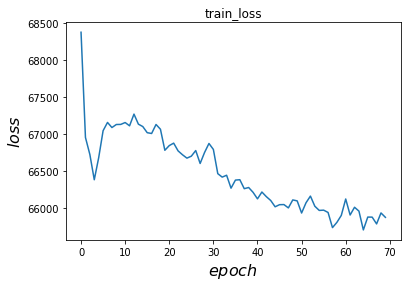

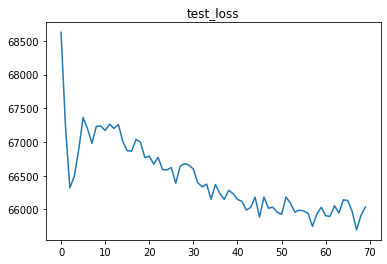

/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


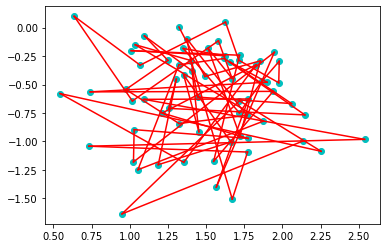

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.00044291061262726454
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: 71932.8744


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71929.1069


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 71807.6217


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 72102.6145


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 3 Train loss: 71761.0260


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71722.2831


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 71557.4696


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71569.9059


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 5 Train loss: 71382.5181


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71256.4370


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 6 Train loss: 71107.5069


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71255.3274


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 7 Train loss: 71220.9929


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70990.0671


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 71007.4246


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71021.7731


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 9 Train loss: 70767.1981


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70896.8391


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 10 Train loss: 70780.8751


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Test loss: 70731.3391


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 11 Train loss: 70689.1634


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 70882.0593


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 70471.4545


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 70345.6848


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 13 Train loss: 70543.3566


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70708.6779


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 14 Train loss: 70317.5992


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70583.5116


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 15 Train loss: 70484.9376


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70373.1061


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 16 Train loss: 70315.6716


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 70259.2286


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 17 Train loss: 70407.3710


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70471.8574


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 18 Train loss: 70434.5374


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70218.5188


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 70270.7090


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70495.3701


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 20 Train loss: 70471.2645


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 70235.4816


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 21 Train loss: 70379.2173


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70076.7869


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 22 Train loss: 70257.1436


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70299.6562


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 70155.2969


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70295.9503


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 70235.0104


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69963.0561


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 25 Train loss: 70120.6891


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 69988.3039


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 26 Train loss: 70059.3589


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70045.2971


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 70216.9359


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70026.4324


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 28 Train loss: 70323.6154


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 69880.4197


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 29 Train loss: 70122.7996


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 69992.8096


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 30 Train loss: 70146.4191


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70073.1102


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 31 Train loss: 70019.2735


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Test loss: 69819.9108


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 32 Train loss: 70086.1562


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 69935.9151


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 70181.1419


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69922.0906


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 70154.7324


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70057.8740


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 35 Train loss: 69983.4929


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70141.7119


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 36 Train loss: 70249.1991


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 70090.6600


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 37 Train loss: 70202.2988


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 70369.4245


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 38 Train loss: 69891.2570


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70353.7392


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 39 Train loss: 70058.4266


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70397.5063


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 40 Train loss: 70220.2871


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Test loss: 70158.3920


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 41 Train loss: 70057.2302


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70379.5774


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 42 Train loss: 70182.2449


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70255.3816


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 43 Train loss: 70209.3559


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70008.4908


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 44 Train loss: 70152.3829


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70113.8161


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 45 Train loss: 69993.0332


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70191.8216


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 46 Train loss: 70127.1882


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70079.8795


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 47 Train loss: 70095.0309


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69500.5446


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 48 Train loss: 69881.8341


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69738.3260


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 49 Train loss: 70031.0319


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70156.8050


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 50 Train loss: 70343.9301


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 70248.8192


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 51 Train loss: 70020.5301


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70039.2270


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 52 Train loss: 70068.2686


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70063.4961


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 53 Train loss: 70272.0090


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70225.5779


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 70088.2428


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70345.8304


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 55 Train loss: 70172.9269


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 70548.7420


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 56 Train loss: 70107.0762


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70266.5272


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 57 Train loss: 70102.7912


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 70121.3209


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 58 Train loss: 70135.5976


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70030.7095


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 59 Train loss: 70176.1287


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 70175.4804


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 60 Train loss: 70201.7334


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70216.6739


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 70055.5864


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70097.3350


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 62 Train loss: 70061.3205


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69902.5522


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 63 Train loss: 70019.6212


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 69862.6845


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 64 Train loss: 70107.3994


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 70176.9478


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 65 Train loss: 70140.6414


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70090.8331


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 66 Train loss: 70267.0999


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69804.4380


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 67 Train loss: 70010.7661


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69940.0806


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 68 Train loss: 70015.5695


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70001.0123


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 70194.5729


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69854.1429


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 70049.5829


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69935.4742


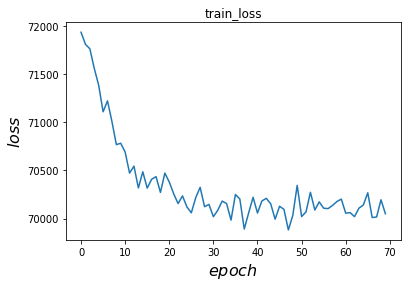

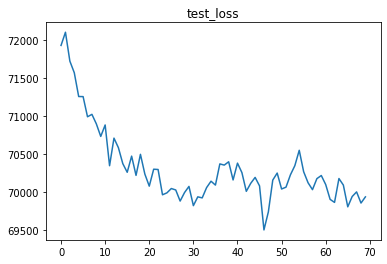

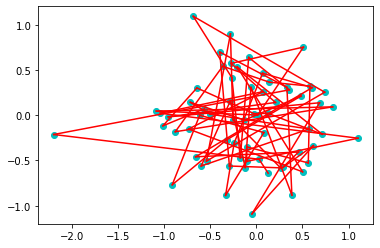

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.03864054156713829
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 387269809613460800.0000


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66809.8445


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 606717731.6341


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 5573055144455343452454912.0000


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 3 Train loss: 4969817305980394094460928.0000


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71616.9695


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 4 Train loss: 70515.7811


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 63755.8788


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 5 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: nan


Setting status of trial#2 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (5,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__
 

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.021797686227311833
      momentum: 0.9
      nesterov: False
      weight_decay: 9.442862452766894e-10
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 62683.4816


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66239.0634


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 2 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: nan


Setting status of trial#3 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (2,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__
 

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 4.0740636186921265e-05
      weight_decay: 6.554302068279559e-08
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: 68289.2449


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68368.4211


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 68563.0989


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68592.9119


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 3 Train loss: 68406.5010


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68467.7649


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 68450.9025


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68572.3294


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 5 Train loss: 68572.7879


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68709.7207


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 6 Train loss: 68409.2731


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68494.2708


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 7 Train loss: 68585.0106


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 68719.6140


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 68421.0309


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68622.8404


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 9 Train loss: 68468.8822


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68463.8966


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 10 Train loss: 68294.2069


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 68257.6474


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 11 Train loss: 68526.5075


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68256.7770


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 12 Train loss: 68310.2009


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68226.4629


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 13 Train loss: 68315.8911


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 68327.3843


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 14 Train loss: 68146.7766


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68173.0118


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 68224.4396


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68010.2581


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 16 Train loss: 68085.4620


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68181.3455


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 17 Train loss: 68085.1903


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68190.0469


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 18 Train loss: 67932.9171


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67959.1241


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 19 Train loss: 68161.0953


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68471.5705


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 68069.9380


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68133.5935


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 21 Train loss: 68160.5443


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Test loss: 68186.1025


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 22 Train loss: 67999.2173


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68283.0646


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 68001.8914


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68154.1571


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 67908.4527


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68114.7723


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 68123.9349


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68063.7107


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 26 Train loss: 68100.9290


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68049.1201


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 27 Train loss: 67874.9601


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68060.7019


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 28 Train loss: 67959.9120


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68152.2605


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 29 Train loss: 68104.7846


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68084.1202


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 30 Train loss: 67824.2241


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67963.0156


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 31 Train loss: 68191.2052


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67888.4444


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 68098.1120


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68043.2413


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 68098.5151


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68067.1321


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 68080.5339


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 67971.0471


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 35 Train loss: 68062.3150


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68125.5036


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 36 Train loss: 68098.8024


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67977.8254


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 37 Train loss: 68068.8929


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67861.7091


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 38 Train loss: 68158.2259


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68160.9590


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 68126.6572


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68176.8334


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 40 Train loss: 67862.8139


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67965.4096


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 41 Train loss: 68108.7985


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68055.9477


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 42 Train loss: 67893.1115


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67855.6235


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 43 Train loss: 67932.0716


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67864.5219


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 44 Train loss: 68047.1702


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67909.3939


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 45 Train loss: 67834.1101


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67886.0528


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 46 Train loss: 68069.3792


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67764.0171


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 47 Train loss: 67940.4979


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68053.4604


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 48 Train loss: 67790.2036


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 67871.0879


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 49 Train loss: 67763.2547


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67845.1634


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 67980.5474


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68052.7854


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 51 Train loss: 67842.6879


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68075.5742


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 52 Train loss: 67833.8654


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67960.2439


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 53 Train loss: 67791.7743


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68002.0009


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 54 Train loss: 67684.3450


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 67952.4615


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 55 Train loss: 67910.2250


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67998.6928


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 56 Train loss: 67834.1723


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 67991.6544


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 57 Train loss: 68007.4044


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67829.1571


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 68079.4944


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67820.9635


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 59 Train loss: 67744.4033


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67946.6517


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 60 Train loss: 67893.0471


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67910.8966


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 61 Train loss: 67680.9314


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67907.6131


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 62 Train loss: 67901.5432


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68045.8479


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 67921.4909


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67931.6972


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 64 Train loss: 67825.3749


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68013.1609


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 65 Train loss: 67997.2865


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67806.4549


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 66 Train loss: 67963.3439


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67702.6322


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 67 Train loss: 67942.3376


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68007.2209


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 68 Train loss: 67932.9364


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67784.9665


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 68025.2150


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67898.4314


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 70 Train loss: 67731.3756


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67673.1163


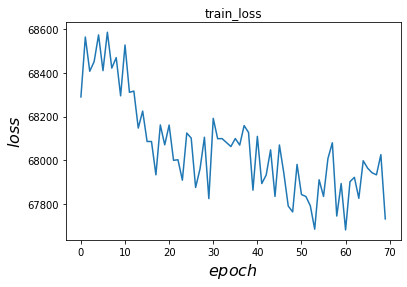

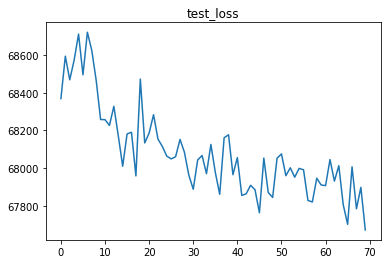

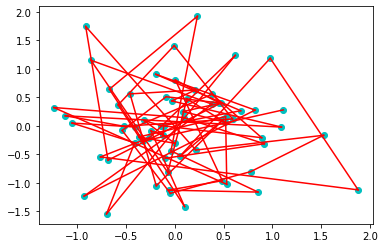

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.004102481496174737
      weight_decay: 0.0001522193400966897
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: 68316.3333


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71953.8877


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 2 Train loss: 72311.7316


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71533.5131


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 3 Train loss: 70893.9406


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 70193.7711


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 70432.8930


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70679.4830


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 5 Train loss: 70609.5419


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70774.0849


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 6 Train loss: 70940.1541


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71038.7270


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 7 Train loss: 71241.5867


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71105.5906


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 71236.9374


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71376.9534


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 9 Train loss: 71316.9756


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71242.3146


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 10 Train loss: 71329.9758


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71115.4361


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 11 Train loss: 71164.2250


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71324.0565


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 71266.0822


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71205.6064


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 13 Train loss: 71419.9474


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71353.9174


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 14 Train loss: 71363.0626


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71509.0945


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 71466.0330


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71356.5924


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 16 Train loss: 71669.3115


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71404.0964


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 17 Train loss: 71582.9294


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71414.8906


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 18 Train loss: 71637.9246


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71558.7536


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 19 Train loss: 71674.0344


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71456.8176


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 20 Train loss: 71637.9885


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71497.8630


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 71569.0451


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71516.9894


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 22 Train loss: 71607.5350


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71438.5570


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 71438.3619


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71579.8254


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 71804.6234


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71565.6362


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 25 Train loss: 71640.7063


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71632.3283


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 26 Train loss: 71542.9666


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71666.5519


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 71692.8051


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71662.7779


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 28 Train loss: 71531.4859


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71654.8471


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 29 Train loss: 71563.1651


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71707.7196


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 30 Train loss: 71739.3739


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71736.1314


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 31 Train loss: 71706.0903


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71667.9586


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 71790.5331


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71595.0944


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 33 Train loss: 71633.3083


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71652.7216


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 34 Train loss: 71819.5419


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 71734.3855


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 35 Train loss: 71632.2744


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 71661.9362


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 36 Train loss: 71567.7113


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71749.8674


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 37 Train loss: 71713.3837


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71676.4481


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 71744.0419


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71555.1769


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 39 Train loss: 71634.9859


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71672.3933


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 40 Train loss: 71558.1021


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71699.3369


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 41 Train loss: 71839.7025


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71787.4681


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 42 Train loss: 71693.1196


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71773.7599


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 43 Train loss: 71757.7886


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71664.7725


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 44 Train loss: 71758.4283


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Test loss: 71629.3829


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 45 Train loss: 71709.1336


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71676.2443


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 46 Train loss: 71581.3499


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71734.1641


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 47 Train loss: 71779.1074


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71729.9559


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 48 Train loss: 71754.0131


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71634.7426


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 49 Train loss: 71631.4249


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71797.2034


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 71596.4307


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71702.9910


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 51 Train loss: 71757.1029


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71816.5656


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 52 Train loss: 71755.1014


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71626.8860


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 53 Train loss: 71818.3211


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71755.6976


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 71680.7759


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71778.7718


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 71716.3296


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 71951.5357


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 71851.7946


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 71719.4667


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 57 Train loss: 71726.8153


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71748.8676


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 71570.8229


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71555.9718


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 59 Train loss: 71914.7139


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71784.4016


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 60 Train loss: 71820.1060


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71798.6465


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 71748.0891


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71703.3384


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 62 Train loss: 71875.7082


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71863.0984


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 71672.3320


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71774.0522


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 64 Train loss: 71923.6724


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 72030.0295


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 65 Train loss: 71737.9599


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 71820.8149


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 66 Train loss: 71852.8152


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 71862.1778


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 67 Train loss: 71824.2516


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71852.6206


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 68 Train loss: 71742.0809


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71726.5719


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 71846.6559


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71884.3198


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 70 Train loss: 71891.6635


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71889.8898


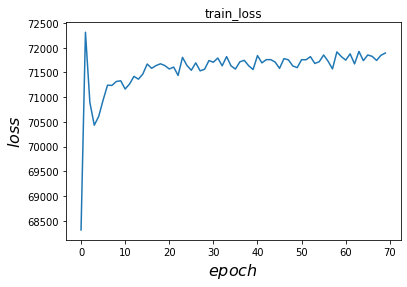

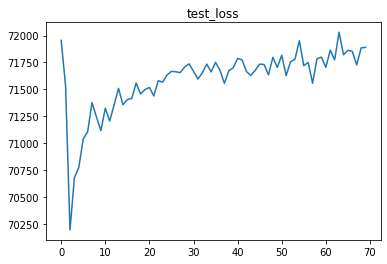

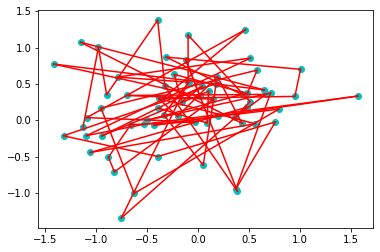

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.02553814334080507
      momentum: 0.9
      nesterov: False
      weight_decay: 7.109817652794455e-07
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: nan


Setting status of trial#6 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (1,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__
 

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0003066020068133185
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 1 Train loss: 65652.4158


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64795.0263


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 2 Train loss: 65090.8309


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65112.8324


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 3 Train loss: 65013.7621


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64874.8972


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 4 Train loss: 64978.5594


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Test loss: 65320.7689


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch: 5 Train loss: 65007.9273


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64633.4117


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 6 Train loss: 64790.4747


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64735.8849


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 7 Train loss: 64948.4504


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65007.4803


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 8 Train loss: 64937.2302


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64545.5722


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 9 Train loss: 64935.2971


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 64718.0319


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 10 Train loss: 64616.2542


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64749.9874


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 11 Train loss: 64732.3199


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64657.8764


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 64738.8734


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64785.5921


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 13 Train loss: 64683.9373


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64655.0708


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 14 Train loss: 64612.8232


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 64623.0309


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 64682.3488


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64441.9656


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 16 Train loss: 64496.4577


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64296.9446


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 17 Train loss: 64493.6698


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64067.8907


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 18 Train loss: 64442.6692


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64431.9848


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 19 Train loss: 64561.2024


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 64371.2783


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 20 Train loss: 64681.0908


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64305.0631


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 64450.9031


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64247.8679


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 22 Train loss: 64424.7084


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64387.9936


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 23 Train loss: 64465.1146


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64576.2587


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 24 Train loss: 64473.3548


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64142.3358


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 64528.6019


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64605.0714


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 26 Train loss: 64161.7469


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64285.5042


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 64502.2518


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64169.1633


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 28 Train loss: 64334.8284


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64152.4199


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 29 Train loss: 64325.0572


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 64339.7334


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 30 Train loss: 64426.5114


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64288.1952


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 31 Train loss: 64480.7922


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Test loss: 64162.2687


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 64331.6857


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64292.6831


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 64249.3991


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64241.5252


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 34 Train loss: 64273.6637


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 64359.6304


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 35 Train loss: 64208.0992


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64685.5814


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 36 Train loss: 64289.8364


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64253.1637


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 37 Train loss: 64240.8368


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64325.6173


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 64099.0952


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64144.4306


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 64242.8057


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Test loss: 64187.8901


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 40 Train loss: 64232.1058


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64285.8752


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 41 Train loss: 64280.8234


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 64266.5714


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 42 Train loss: 64272.9932


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64238.2477


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 43 Train loss: 64325.5542


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64153.2523


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 44 Train loss: 64106.8188


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Test loss: 63915.9714


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 45 Train loss: 64310.7701


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64212.5604


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 46 Train loss: 64415.4506


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64229.6828


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 47 Train loss: 64215.1534


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64259.2532


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 48 Train loss: 64370.8666


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64451.2544


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 49 Train loss: 64091.5894


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64524.4553


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 64264.3833


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64432.0692


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 51 Train loss: 64315.8859


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64245.5166


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 52 Train loss: 64321.7127


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 64480.7557


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 53 Train loss: 64386.7601


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64417.4479


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 64035.6493


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64204.8003


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 64213.2437


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64112.2213


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 56 Train loss: 64186.3089


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64162.2672


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 57 Train loss: 64447.4917


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64353.4258


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 64240.1232


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 64288.1074


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 59 Train loss: 64572.8613


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64519.1974


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 60 Train loss: 64350.5108


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64451.2947


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 61 Train loss: 64463.9987


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64447.8132


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 64122.6618


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 64590.6998


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 63 Train loss: 64314.8947


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64515.8451


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 64 Train loss: 64406.8278


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64370.3361


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 65 Train loss: 64484.9374


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 63970.4912


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 66 Train loss: 64253.9771


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64428.7819


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 67 Train loss: 64195.4126


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64507.8953


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 68 Train loss: 64450.0028


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 64315.7709


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 64459.0399


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 64180.4033


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 64478.9457


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 64489.5808


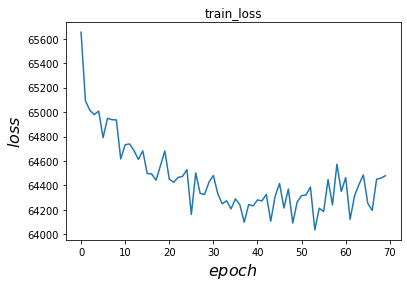

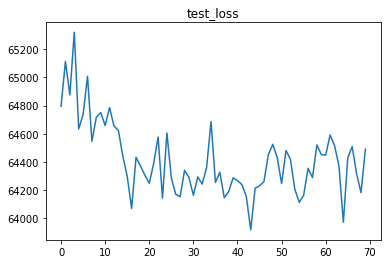

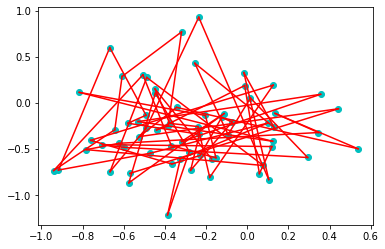

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 1.6081185784757435e-05
      weight_decay: 7.931531116353951e-05
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 67084.4955


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67066.1197


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 2 Train loss: 66960.0264


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66851.8233


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 3 Train loss: 66884.9758


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67069.7479


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 67070.4759


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66830.3032


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 5 Train loss: 66934.0240


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66921.3949


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 6 Train loss: 67008.4169


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66976.5814


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 7 Train loss: 66937.3554


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66966.5630


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 67116.1569


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67266.4082


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 9 Train loss: 66991.3024


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67001.1686


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 10 Train loss: 67038.1108


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66985.1479


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch: 11 Train loss: 66791.8711


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67146.9139


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 66997.4434


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67038.2575


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 13 Train loss: 66957.6369


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67262.3811


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 14 Train loss: 67036.2156


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66994.7029


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 67061.7105


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67138.5283


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 16 Train loss: 67030.9999


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66956.0685


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 17 Train loss: 67152.0166


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66989.8594


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 18 Train loss: 67270.4089


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67186.8351


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 67117.7530


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66857.3854


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 67088.6364


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67230.4705


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 67096.4444


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67180.3026


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 22 Train loss: 67071.1913


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67029.0158


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 23 Train loss: 67110.0173


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66988.0202


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 24 Train loss: 67265.7946


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67241.1161


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 25 Train loss: 67110.7422


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67191.5548


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 26 Train loss: 67200.7339


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66945.8339


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 67147.7732


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67147.6220


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 28 Train loss: 67166.9375


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67091.8123


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 29 Train loss: 67085.9323


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67182.7731


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 30 Train loss: 67133.3789


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Test loss: 67222.4229


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 31 Train loss: 67221.5387


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67121.2931


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 32 Train loss: 67114.9520


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67013.8071


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 67141.2786


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67228.6826


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 67029.7286


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67175.8455


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 35 Train loss: 67321.5096


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67137.1765


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 36 Train loss: 67269.7384


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67131.8466


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 37 Train loss: 67113.8181


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67171.1588


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 38 Train loss: 66966.8763


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67308.6913


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 39 Train loss: 67097.0681


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67049.6113


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 40 Train loss: 67263.0780


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67262.7170


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 41 Train loss: 67024.2254


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67285.1225


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 42 Train loss: 67105.7259


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67183.1961


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 43 Train loss: 67168.5773


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67298.2896


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 44 Train loss: 67106.1802


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67192.2536


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 45 Train loss: 67161.7994


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67231.4621


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 46 Train loss: 67129.9691


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67027.5425


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 47 Train loss: 67161.3636


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67083.9719


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 48 Train loss: 67228.5810


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66970.2204


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 49 Train loss: 67111.3668


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67235.6352


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 50 Train loss: 67127.0802


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67216.3670


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 51 Train loss: 67241.5761


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67393.5591


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 52 Train loss: 67074.4960


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67134.5401


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 53 Train loss: 67210.7381


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67050.7783


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 54 Train loss: 67119.1310


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67233.4343


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 55 Train loss: 67189.6130


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67253.5696


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 56 Train loss: 67277.3962


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67173.2554


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 57 Train loss: 67284.2529


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67153.5839


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 58 Train loss: 67098.5981


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67064.2016


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 59 Train loss: 67071.5920


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67209.4981


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 60 Train loss: 67145.7541


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66979.0620


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 67148.0696


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67169.8095


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 66943.8071


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67064.0061


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 67101.7540


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67370.8932


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 64 Train loss: 67134.8649


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67280.4601


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 65 Train loss: 67059.0779


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67031.9122


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 66 Train loss: 67102.0751


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67120.5844


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 67 Train loss: 67010.0859


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67136.3890


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 68 Train loss: 66997.1831


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67403.5434


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 67128.2538


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67111.9484


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 70 Train loss: 67041.2129


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67112.5476


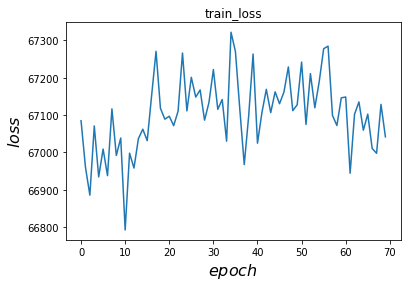

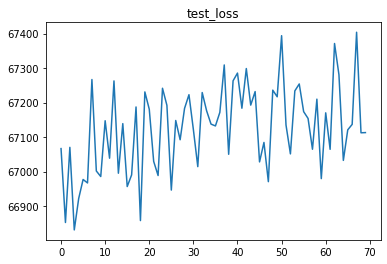

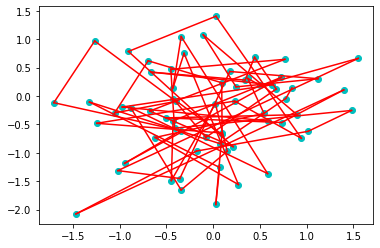

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.0008871858520967214
      momentum: 0.9
      nesterov: False
      weight_decay: 0.00015104338415386162
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 65303.8089


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66716.3752


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 67460.4641


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67797.7584


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 3 Train loss: 67811.7211


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67321.1318


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 67185.4919


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66892.0125


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 5 Train loss: 66912.5409


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 67034.0604


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 6 Train loss: 66962.7810


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66873.2247


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 7 Train loss: 66709.2826


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66750.8898


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 8 Train loss: 66686.1044


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66680.1742


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 9 Train loss: 66524.3376


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66600.9932


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 10 Train loss: 66753.0111


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66563.0176


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 11 Train loss: 66528.1355


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66557.0243


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 12 Train loss: 66598.8277


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66506.3409


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 13 Train loss: 66710.2144


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66624.8259


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 14 Train loss: 66492.8801


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66392.4007


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 15 Train loss: 66455.0939


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66553.7491


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 16 Train loss: 66353.1355


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66415.4176


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 17 Train loss: 66331.9576


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66471.4264


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 18 Train loss: 66330.1769


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66464.0931


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 66372.2652


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66352.9109


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 20 Train loss: 66474.6946


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 66268.0274


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 21 Train loss: 66375.9042


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66468.2831


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch: 22 Train loss: 66322.8791


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66450.2341


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 23 Train loss: 66433.1402


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66275.0459


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 24 Train loss: 66348.4220


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66229.6874


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 25 Train loss: 66338.9769


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66249.7979


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 26 Train loss: 66418.5474


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 66376.1052


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 27 Train loss: 66420.6923


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66294.9754


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 28 Train loss: 66120.0606


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66490.5592


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 29 Train loss: 66391.2175


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66329.6151


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 30 Train loss: 66312.0564


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66172.6351


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 31 Train loss: 66339.4935


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66394.7140


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 32 Train loss: 66277.9744


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66403.9436


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 33 Train loss: 66219.9522


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 66426.6984


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 66139.3649


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66169.7880


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 35 Train loss: 66330.4806


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66268.0799


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 36 Train loss: 66221.7591


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66407.9202


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 37 Train loss: 66315.1569


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66298.4564


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 38 Train loss: 66299.4758


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66149.0584


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 66275.7921


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66256.6660


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 40 Train loss: 66154.9439


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66354.8331


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 41 Train loss: 66196.5311


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66271.2880


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 42 Train loss: 66212.3246


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66106.7353


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 43 Train loss: 66328.2009


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66164.1875


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 44 Train loss: 66438.6926


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65961.3516


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 45 Train loss: 66224.2824


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66455.3305


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 46 Train loss: 66194.8985


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66009.3739


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch: 47 Train loss: 66442.8631


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66125.4272


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 48 Train loss: 66210.3765


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66288.0713


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 49 Train loss: 66194.8911


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66138.6726


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 50 Train loss: 66145.0673


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66324.5611


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 51 Train loss: 66139.7940


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66156.0312


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 52 Train loss: 66343.0532


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66208.4600


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 53 Train loss: 66335.9743


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66077.1295


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 66183.2265


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66029.2466


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 55 Train loss: 66355.3660


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66199.8011


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 66316.9735


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66177.4347


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 57 Train loss: 66149.9966


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 66138.5714


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 66342.4731


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 66203.5172


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 59 Train loss: 66165.3200


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66129.2636


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 60 Train loss: 66086.0301


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66039.0281


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 61 Train loss: 65951.4971


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66211.9189


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 66366.3684


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65986.1425


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 63 Train loss: 66131.2895


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66029.6263


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 64 Train loss: 66200.3646


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66260.6731


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 65 Train loss: 66200.4044


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 65957.0960


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 66 Train loss: 66137.0726


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66091.5926


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 67 Train loss: 66146.3861


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66139.7660


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 68 Train loss: 66168.2155


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Test loss: 66031.9825


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 69 Train loss: 66119.9110


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66158.6546


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 70 Train loss: 66135.7355


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66141.1870


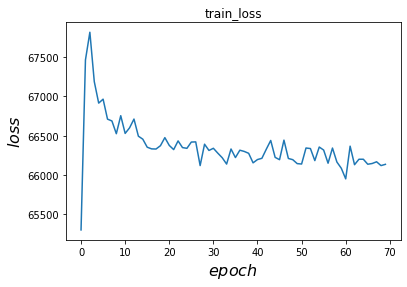

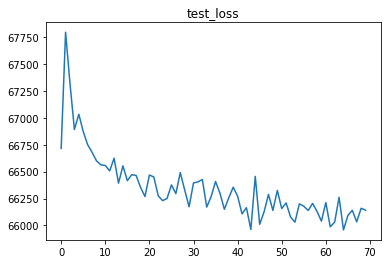

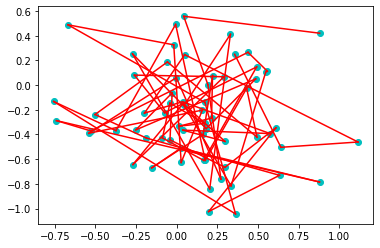

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.02655972427585978
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: nan


Setting status of trial#10 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (1,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__


Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.009563091386611417
      momentum: 0.9
      nesterov: False
      weight_decay: 0.00011969704802949952
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 23494799019.6787


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 75876.6284


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 2 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: nan


Setting status of trial#11 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (2,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__


Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.0014081808015277268
      weight_decay: 2.8772310966476896e-09
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 69829.5145


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Test loss: 69369.6190


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 2 Train loss: 69429.5431


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69425.8326


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 3 Train loss: 69197.2991


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69660.0807


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 4 Train loss: 69743.1941


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69853.1259


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 5 Train loss: 69311.3524


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68905.1632


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 6 Train loss: 69108.8442


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69246.4185


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 7 Train loss: 69266.8119


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 69226.8403


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 8 Train loss: 68906.0470


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 68956.3344


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 9 Train loss: 69060.6904


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68842.5333


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 10 Train loss: 69081.5174


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68980.9286


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 11 Train loss: 68726.5335


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69024.7446


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 12 Train loss: 68834.5610


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68902.9042


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 13 Train loss: 68872.7222


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68740.0484


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 14 Train loss: 68711.2379


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68698.7589


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 15 Train loss: 68717.9631


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68644.2731


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 16 Train loss: 68752.7020


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68687.8571


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 17 Train loss: 68590.3904


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68588.5849


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 18 Train loss: 68523.3766


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68852.9355


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 19 Train loss: 68684.3848


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68701.4315


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 68661.7665


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68502.8049


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 68300.8231


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68421.8271


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 22 Train loss: 68690.8972


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68458.0364


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 23 Train loss: 68592.3641


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68486.9960


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 68555.4664


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68394.2993


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 68489.1279


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68366.9287


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 26 Train loss: 68424.2251


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68316.2692


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 68498.9875


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68358.4689


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 28 Train loss: 68286.3071


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68322.1900


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch: 29 Train loss: 68458.3034


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68201.0276


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 30 Train loss: 68626.9926


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68201.2269


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 31 Train loss: 68563.1282


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68454.5406


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 68270.0594


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Test loss: 68157.5281


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 68213.1919


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68240.9238


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 68170.7719


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68250.0243


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 35 Train loss: 68401.3901


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68474.9801


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 36 Train loss: 68322.5589


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Test loss: 68524.1606


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 37 Train loss: 68266.6957


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68337.1034


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 68403.4202


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68313.8411


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 39 Train loss: 68153.1390


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68205.5290


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 40 Train loss: 68186.1689


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68357.9126


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 41 Train loss: 68171.2316


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68239.9726


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 42 Train loss: 68349.3656


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68095.9760


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 43 Train loss: 68180.5571


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68225.0822


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 44 Train loss: 68019.3825


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68208.0040


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 45 Train loss: 68273.8174


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68332.1486


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 46 Train loss: 68055.0635


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 68053.3976


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 47 Train loss: 68064.8015


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68325.7162


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 48 Train loss: 68079.5070


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68295.8812


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 49 Train loss: 68056.1184


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68162.7941


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 50 Train loss: 68021.1320


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68264.7271


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 51 Train loss: 68290.0146


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 67963.5127


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 52 Train loss: 68065.4651


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68155.5252


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 53 Train loss: 68133.6599


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68107.9409


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 54 Train loss: 68264.5784


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68031.7212


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 67929.0832


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68015.4017


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 56 Train loss: 68097.1704


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67983.9862


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 57 Train loss: 67861.1493


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67913.4851


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 68064.9448


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68057.8814


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 59 Train loss: 67866.6791


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67974.4689


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 60 Train loss: 68020.4956


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68019.7690


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 67866.0411


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67864.5066


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 68159.3826


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68145.4764


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 63 Train loss: 68019.2979


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68077.2949


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 64 Train loss: 67974.3559


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67987.7892


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 65 Train loss: 67984.7424


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67924.7019


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 66 Train loss: 67862.9339


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68131.1700


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 67 Train loss: 67718.1573


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 67813.1566


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 68 Train loss: 67853.8571


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67875.4114


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 69 Train loss: 68045.9785


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Test loss: 67812.3651


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 67838.3820


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67880.7074


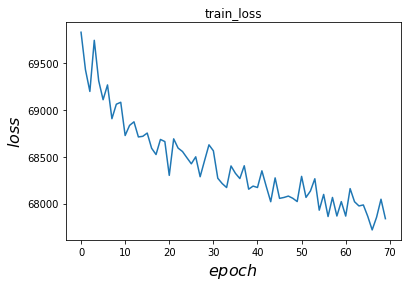

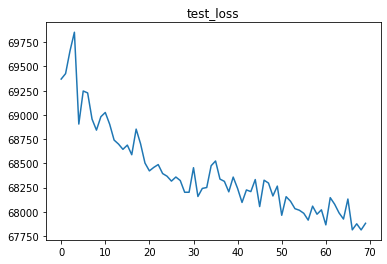

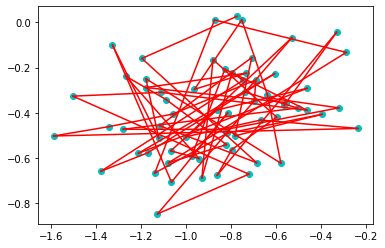

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0001053469649504931
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 1 Train loss: 70712.5696


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70901.6366


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 2 Train loss: 70964.9305


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71099.7349


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 3 Train loss: 70813.2640


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 70698.6393


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 4 Train loss: 70573.6325


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 70335.8171


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 5 Train loss: 70659.0348


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70504.3114


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 6 Train loss: 70363.3384


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 70378.2740


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 7 Train loss: 70193.9176


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 70166.4114


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 8 Train loss: 70284.0126


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 70159.2506


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 9 Train loss: 70055.3782


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 70106.2684


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 10 Train loss: 70050.5395


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 69861.9869


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 11 Train loss: 69756.9254


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69631.1665


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 69883.7459


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69777.7017


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 13 Train loss: 69688.8761


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69709.8736


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 14 Train loss: 69900.9282


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69411.8959


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 15 Train loss: 69615.4844


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 69504.9466


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 16 Train loss: 69696.4329


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 69573.1439


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 17 Train loss: 69652.8594


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69567.5985


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 18 Train loss: 69503.9130


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69300.5779


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 19 Train loss: 69541.7726


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Test loss: 69474.0242


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 20 Train loss: 69335.1009


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69332.8196


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 21 Train loss: 69249.3059


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 69493.5371


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 22 Train loss: 69380.3986


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 69349.1422


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 23 Train loss: 69220.2616


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68982.3914


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 69211.4064


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69151.9610


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 69356.3736


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 69118.3444


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 26 Train loss: 69033.8971


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68975.1059


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 27 Train loss: 69163.4618


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 69038.4669


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 28 Train loss: 69089.1779


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 69101.0036


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 29 Train loss: 69108.4466


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69336.4311


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 30 Train loss: 69170.7346


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 69135.8694


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 31 Train loss: 69009.6010


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68925.4974


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 32 Train loss: 68964.7895


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69182.7508


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 33 Train loss: 69120.6816


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69079.4672


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 34 Train loss: 69052.8815


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68785.9199


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 35 Train loss: 68952.5629


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68982.0291


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 36 Train loss: 69034.5485


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68708.1590


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 37 Train loss: 68767.2041


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69067.2541


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 68949.9554


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 69005.8114


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 39 Train loss: 68742.4799


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 69051.7923


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 40 Train loss: 68920.3851


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68935.3820


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 41 Train loss: 68870.3074


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68957.1503


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 42 Train loss: 68723.3167


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Test loss: 69114.4010


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 43 Train loss: 68800.9029


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 69096.4664


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 44 Train loss: 68846.8621


100%|██████████| 8/8 [00:03<00:00,  2.79it/s]


Test loss: 68882.3169


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 45 Train loss: 68852.8258


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68734.6449


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 46 Train loss: 68876.3374


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68767.9191


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 47 Train loss: 68684.9782


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68743.0176


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 48 Train loss: 68783.2861


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68841.3462


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 49 Train loss: 68727.0961


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68921.2101


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 68668.9800


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68926.9666


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 51 Train loss: 68933.2149


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68753.7881


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 52 Train loss: 68925.4505


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68849.2804


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 53 Train loss: 68981.1071


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68790.8136


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 54 Train loss: 68947.9921


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Test loss: 69091.8212


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 55 Train loss: 68950.0819


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68867.6803


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 56 Train loss: 68841.5963


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68932.0974


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 57 Train loss: 68744.2518


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68758.7686


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 68935.0232


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68859.3819


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 59 Train loss: 68907.3466


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68895.1730


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 60 Train loss: 68752.5119


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68778.2594


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 68786.2726


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68907.4801


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 62 Train loss: 68643.9387


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68758.7872


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 68772.1846


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68857.1036


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 64 Train loss: 68770.1206


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68489.3160


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 65 Train loss: 68761.0544


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68990.7881


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 66 Train loss: 68731.4070


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68864.7517


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 67 Train loss: 68756.8064


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68924.7673


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 68 Train loss: 68784.0607


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68695.8614


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 69 Train loss: 68672.9833


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68708.8595


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 70 Train loss: 68719.9759


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68723.9848


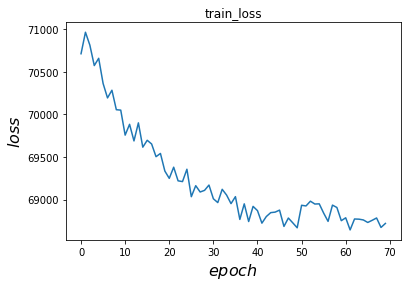

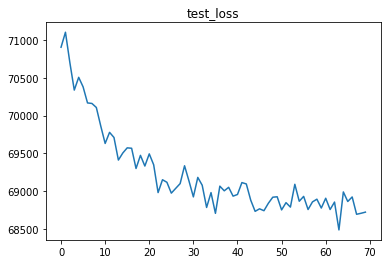

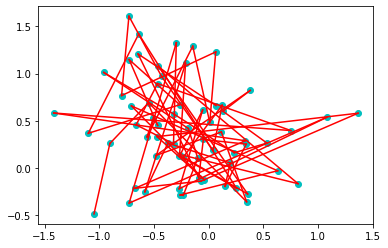

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.0013239124803392465
      momentum: 0.9
      nesterov: False
      weight_decay: 2.6192128474598086e-07
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: 69190.3434


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 69185.0789


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 69511.0339


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Test loss: 69034.5661


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 3 Train loss: 68737.1106


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 68843.5648


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 4 Train loss: 68454.7311


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68119.8589


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 5 Train loss: 68798.0733


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68794.8999


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 6 Train loss: 68763.4699


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68670.6946


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 7 Train loss: 68775.4082


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 69003.9476


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 8 Train loss: 68778.1516


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68656.5732


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 9 Train loss: 68636.0461


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68713.9934


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 10 Train loss: 68710.7333


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68420.5378


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 11 Train loss: 68630.4050


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68680.4714


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 12 Train loss: 68589.4204


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68648.4832


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 13 Train loss: 68437.7564


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68450.4869


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 14 Train loss: 68434.8156


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68291.6505


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 68685.7838


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68330.0014


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 16 Train loss: 68348.0709


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68700.5104


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 17 Train loss: 68554.7903


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68535.4660


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 18 Train loss: 68360.9909


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68562.8247


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 19 Train loss: 68224.4171


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68470.7651


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 20 Train loss: 68399.4851


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68294.7074


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 21 Train loss: 68462.4621


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68637.2179


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 22 Train loss: 68458.3099


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 68507.9306


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 68271.9359


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Test loss: 68504.4689


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 24 Train loss: 68520.5053


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68472.0789


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 25 Train loss: 68291.0624


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68256.7339


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 26 Train loss: 68355.7079


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 68373.9731


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 27 Train loss: 68114.7589


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68466.1110


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 28 Train loss: 68400.7245


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68209.5468


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 29 Train loss: 68502.7004


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 68416.4066


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 30 Train loss: 68413.5809


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68407.0537


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 31 Train loss: 68353.9554


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68462.7920


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 32 Train loss: 68419.6466


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68258.1981


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 68390.3478


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68059.8074


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 34 Train loss: 68407.1449


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68319.1632


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 35 Train loss: 68166.9936


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68413.2345


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 36 Train loss: 68229.8184


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68352.2552


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 37 Train loss: 68305.0356


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68471.5422


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 68217.2451


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68216.0205


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 68213.6455


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68365.4142


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 40 Train loss: 68263.2088


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68258.8719


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 41 Train loss: 68282.4655


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68342.4564


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 42 Train loss: 68296.3089


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68299.2479


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 43 Train loss: 68334.2464


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68408.1717


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 44 Train loss: 68301.9716


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68351.8525


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 45 Train loss: 68371.4612


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68310.2065


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 46 Train loss: 68095.8682


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68288.2649


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 47 Train loss: 68265.1490


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68362.8634


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 48 Train loss: 68267.3131


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68355.9709


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 49 Train loss: 68336.4945


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68126.7543


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 50 Train loss: 68272.9041


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68165.2230


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 51 Train loss: 68298.5953


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68488.1412


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 52 Train loss: 68413.4349


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 68176.2914


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 53 Train loss: 68374.3030


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68276.0956


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 54 Train loss: 68160.5173


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Test loss: 68446.4994


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 68109.6869


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68132.2170


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 68299.6066


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68137.6381


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 57 Train loss: 68197.8642


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68206.8222


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 58 Train loss: 68251.1035


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68134.8460


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 59 Train loss: 68153.1614


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68091.9150


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 60 Train loss: 68120.3070


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68145.1649


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 61 Train loss: 68212.0836


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68264.5901


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 68191.0009


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68309.2572


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 63 Train loss: 68367.3872


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68233.1596


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 64 Train loss: 68218.8210


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68279.2177


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 65 Train loss: 68141.9349


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68317.7280


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 66 Train loss: 68290.2936


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68148.9605


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 67 Train loss: 68198.1314


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68051.1539


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 68 Train loss: 68255.6354


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67927.1723


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 69 Train loss: 68220.0857


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68291.1991


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 70 Train loss: 68198.3259


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68204.4909


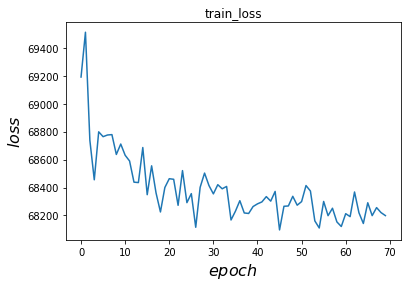

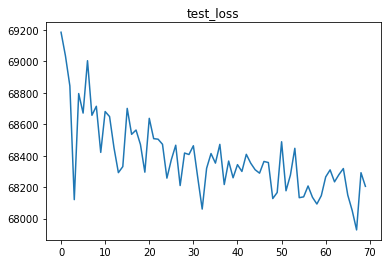

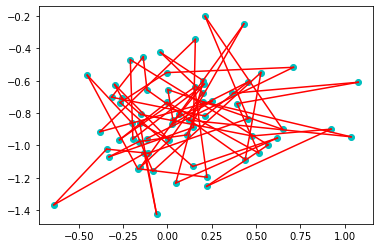

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.00040144118257498236
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 1 Train loss: 65842.3364


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 65519.4259


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 2 Train loss: 65584.9325


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 65712.9344


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 3 Train loss: 65982.7739


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66194.0012


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 4 Train loss: 65989.2684


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 65901.0996


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 5 Train loss: 66178.8721


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66202.7411


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 6 Train loss: 66162.6849


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66238.3229


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 7 Train loss: 66484.4894


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66418.2767


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 66514.3990


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66236.3818


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 9 Train loss: 66639.6672


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66333.6423


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 10 Train loss: 66573.1911


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66513.2201


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 11 Train loss: 66301.8222


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66578.5161


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 66638.3518


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66485.5379


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 13 Train loss: 66561.5339


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66571.6590


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 14 Train loss: 66380.4326


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66729.4896


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 15 Train loss: 66478.4750


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66785.4821


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 16 Train loss: 66690.4239


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66448.3856


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 17 Train loss: 66556.4896


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66698.9234


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 18 Train loss: 66735.9185


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66355.5951


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 66723.9199


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 66402.9628


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 66659.4112


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66595.9972


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 21 Train loss: 66676.8991


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66714.2901


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 22 Train loss: 66607.2870


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66364.6891


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 23 Train loss: 66595.2570


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Test loss: 66597.3504


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 66559.1811


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66742.0290


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 66459.1333


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66579.9249


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 26 Train loss: 66677.9776


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66374.3784


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 27 Train loss: 66520.2541


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66734.6246


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 28 Train loss: 66684.3509


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 66800.2441


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 29 Train loss: 66667.4689


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66873.6406


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 30 Train loss: 66608.7636


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66908.6232


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 31 Train loss: 66718.4899


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66788.9878


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 66798.5433


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66765.5209


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 33 Train loss: 66772.2709


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66644.3802


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 34 Train loss: 66636.5441


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66512.8364


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 35 Train loss: 66799.0431


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67004.8166


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 36 Train loss: 66790.3227


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67095.8279


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 37 Train loss: 66656.8290


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66840.5516


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 38 Train loss: 66754.6056


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66693.7946


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 66704.0011


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66784.0374


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 40 Train loss: 66731.6812


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66729.2831


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 41 Train loss: 66746.7402


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 66657.8093


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 42 Train loss: 66782.5656


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66562.4803


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 43 Train loss: 66548.9342


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66490.9475


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 44 Train loss: 66589.6104


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66538.5861


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 45 Train loss: 66714.3839


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66555.0444


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 46 Train loss: 66729.7712


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66724.7926


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 47 Train loss: 66757.4573


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66881.4304


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 48 Train loss: 66682.2084


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67071.0604


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 49 Train loss: 66789.9449


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66830.2532


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 50 Train loss: 66819.7062


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 66877.3207


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 51 Train loss: 66812.1500


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66712.9379


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 52 Train loss: 66591.0158


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66263.6766


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 53 Train loss: 66575.3310


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66501.2011


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 66641.4676


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66557.9080


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 66792.2813


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66423.7609


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 66873.8999


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66456.3574


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 57 Train loss: 66706.6672


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66553.6219


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 66675.3024


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66702.0534


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 59 Train loss: 66865.0916


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66822.2184


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 60 Train loss: 66604.5291


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 66675.9503


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 61 Train loss: 66647.7599


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66703.4809


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 66816.0279


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67096.1584


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 66547.2520


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66818.5946


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 64 Train loss: 66839.4959


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67071.6739


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 65 Train loss: 66740.5286


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 66986.6109


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch: 66 Train loss: 66758.1686


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 66623.1961


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 67 Train loss: 66791.1512


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 66616.2698


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 68 Train loss: 66721.5516


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 66670.0419


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch: 69 Train loss: 66744.8365


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 66593.8399


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 66512.3894


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 66753.8153


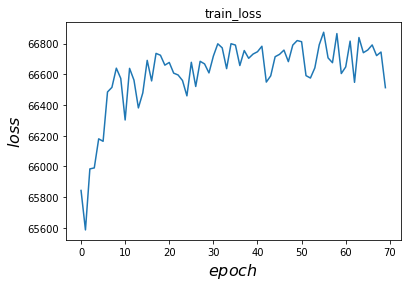

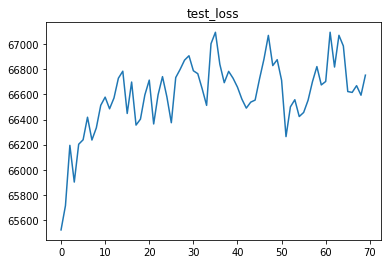

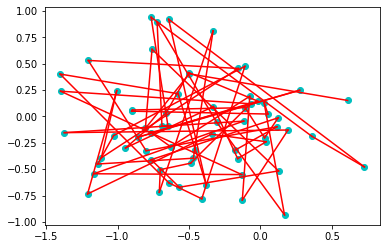

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0007391969939725589
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: 71591.4481


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 72236.8831


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 2 Train loss: 72052.7146


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 72083.3894


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 3 Train loss: 71958.1389


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 72074.6726


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 4 Train loss: 71977.5941


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71955.6660


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 5 Train loss: 71750.8730


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 72135.7771


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 6 Train loss: 71652.9491


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71939.1623


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 7 Train loss: 71963.8552


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 72248.3193


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 8 Train loss: 71899.0830


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 72150.0649


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 9 Train loss: 71917.9851


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 72388.3064


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 10 Train loss: 71625.0184


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71844.2247


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 11 Train loss: 71876.8159


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71987.5505


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 71861.6051


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71828.5655


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 13 Train loss: 71746.5953


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71612.9969


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 14 Train loss: 72044.1129


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Test loss: 71700.2346


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 15 Train loss: 71725.7036


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71814.6906


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 16 Train loss: 71384.9204


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Test loss: 72062.3071


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 17 Train loss: 71713.2614


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 72394.0091


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 18 Train loss: 71599.5584


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 72183.6970


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 19 Train loss: 71627.2866


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71748.2225


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 20 Train loss: 71536.7276


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71649.2709


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 21 Train loss: 71656.7309


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71579.3831


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch: 22 Train loss: 71461.2506


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71698.4264


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 23 Train loss: 71637.5087


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71759.0353


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 24 Train loss: 71467.2761


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71716.9380


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 25 Train loss: 71462.9295


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 72077.8723


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 26 Train loss: 71457.0110


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71957.9086


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 27 Train loss: 71484.1163


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71618.4635


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 28 Train loss: 71547.5309


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71454.6805


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 29 Train loss: 71674.1529


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71498.2627


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 30 Train loss: 71582.0093


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71508.2692


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 31 Train loss: 71449.5082


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71190.1934


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 32 Train loss: 71703.6101


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71063.4326


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 33 Train loss: 71489.4482


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71274.0700


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 34 Train loss: 71343.6746


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71234.4386


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 35 Train loss: 71282.3055


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71526.4834


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 36 Train loss: 71343.0521


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71732.0347


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 37 Train loss: 71388.8559


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71851.9357


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 71595.7813


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71526.7340


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 39 Train loss: 71389.0616


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71261.4736


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 40 Train loss: 71334.5621


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71107.0481


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 41 Train loss: 71107.5433


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 70822.2112


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 42 Train loss: 71435.4741


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71240.1956


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 43 Train loss: 71430.7381


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71263.5556


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 44 Train loss: 71435.7639


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71361.2676


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 45 Train loss: 71278.4926


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71431.7351


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 46 Train loss: 71339.5444


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71603.5366


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 47 Train loss: 71255.9194


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71288.5015


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 48 Train loss: 71389.7756


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71450.6293


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 49 Train loss: 71138.6130


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71703.5399


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 50 Train loss: 71300.0433


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71519.6776


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 51 Train loss: 71142.4165


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71464.1056


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 52 Train loss: 71239.4153


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71359.0055


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 53 Train loss: 71287.3763


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71219.7874


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 54 Train loss: 71086.1336


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71319.1062


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 55 Train loss: 71288.5025


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71332.9125


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 56 Train loss: 71168.1824


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71249.7111


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 57 Train loss: 71385.4690


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71419.9324


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 58 Train loss: 71105.8859


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 71502.9942


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 59 Train loss: 71182.0354


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71535.7066


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 60 Train loss: 71202.1411


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71232.8631


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 61 Train loss: 70903.8250


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 71291.9783


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 62 Train loss: 71072.3093


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71261.5111


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 63 Train loss: 71050.3474


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71141.2196


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 64 Train loss: 70872.1503


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71055.4199


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 65 Train loss: 71059.3619


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71014.7362


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 66 Train loss: 71097.5409


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 71222.3774


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 67 Train loss: 71079.6895


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 71247.4154


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 68 Train loss: 71109.9918


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 71392.5881


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 69 Train loss: 70893.3481


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 71191.5130


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 70 Train loss: 71075.9776


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 71053.1564


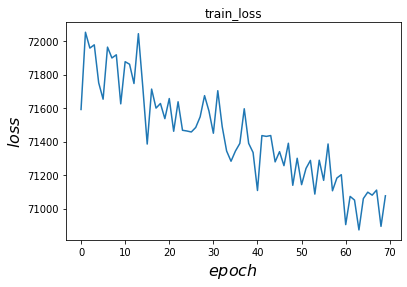

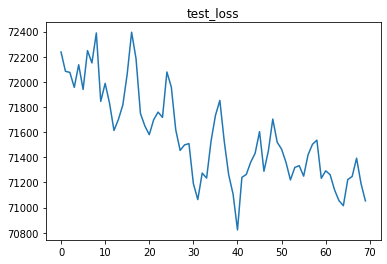

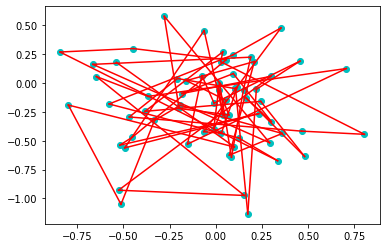

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0008111985015005474
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 1 Train loss: 68448.6745


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68122.0436


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 2 Train loss: 68165.5196


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68208.4201


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch: 3 Train loss: 68011.5532


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68021.9221


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 4 Train loss: 67934.8679


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67814.1171


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 5 Train loss: 67988.2911


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 68023.2871


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 6 Train loss: 67811.1469


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67836.9401


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 7 Train loss: 67777.6260


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68004.5035


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 8 Train loss: 67964.1511


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67914.0543


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 9 Train loss: 67789.3020


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67977.5772


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 10 Train loss: 67981.6771


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Test loss: 68153.2626


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 11 Train loss: 67836.8240


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68274.3376


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 12 Train loss: 67801.2270


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68500.5023


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 13 Train loss: 68063.6610


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68106.7129


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 14 Train loss: 67995.5622


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68048.5551


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 15 Train loss: 67934.8014


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68289.6648


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 16 Train loss: 67920.8927


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68392.0243


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 17 Train loss: 67995.8703


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 68367.7789


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 18 Train loss: 67765.1361


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68134.5361


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 19 Train loss: 67996.3916


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Test loss: 67903.0906


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 20 Train loss: 68175.6062


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67638.1601


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch: 21 Train loss: 67889.8429


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67317.4344


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 22 Train loss: 67987.5551


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67594.7964


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 23 Train loss: 67824.2645


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67730.5411


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 24 Train loss: 68099.5321


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67688.6639


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 25 Train loss: 67974.6309


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67749.7622


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 26 Train loss: 68025.0114


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67904.5604


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 27 Train loss: 67898.5802


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67893.7443


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 28 Train loss: 67915.0261


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67664.2831


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 29 Train loss: 67959.3948


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 67323.0876


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 30 Train loss: 68090.6631


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67263.4021


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 31 Train loss: 68023.8898


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67928.8671


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch: 32 Train loss: 68120.3391


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68083.0390


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 33 Train loss: 68006.5194


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Test loss: 68103.5296


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 34 Train loss: 67894.8016


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68288.0211


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 35 Train loss: 67787.6951


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 68135.9928


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 36 Train loss: 68119.0547


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68186.6101


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 37 Train loss: 67996.9279


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68125.6675


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 38 Train loss: 67945.1214


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Test loss: 67785.8731


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 39 Train loss: 67871.5096


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Test loss: 67684.2694


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 40 Train loss: 68151.4202


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67625.4061


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch: 41 Train loss: 68105.1176


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67779.3839


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 42 Train loss: 67984.4000


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67656.7935


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch: 43 Train loss: 67921.4696


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67696.1563


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 44 Train loss: 67911.9839


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67344.7154


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 45 Train loss: 67961.5894


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67482.7527


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 46 Train loss: 67922.7255


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67904.2674


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 47 Train loss: 67944.4726


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68288.4566


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 48 Train loss: 68128.5676


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 68684.3445


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 49 Train loss: 67846.1974


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 68119.9636


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 50 Train loss: 67940.5108


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67876.4204


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 51 Train loss: 67851.5932


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 68183.6851


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 52 Train loss: 67962.1282


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 68112.4485


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 53 Train loss: 67914.8652


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67984.5373


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 54 Train loss: 67991.0063


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67703.4414


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 55 Train loss: 67909.6765


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67705.2094


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 56 Train loss: 67861.2519


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Test loss: 67629.0176


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 57 Train loss: 68036.0236


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67411.6750


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 58 Train loss: 67767.6445


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67659.7924


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch: 59 Train loss: 67974.9399


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67653.5244


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 60 Train loss: 67971.2408


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67618.3900


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 61 Train loss: 67695.3881


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Test loss: 67956.0551


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 62 Train loss: 67697.7141


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: 67727.9929


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 63 Train loss: 67993.1191


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67569.4593


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 64 Train loss: 67971.7542


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Test loss: 67787.7462


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 65 Train loss: 67954.7411


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67587.9263


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 66 Train loss: 67734.9764


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Test loss: 67711.4779


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch: 67 Train loss: 67797.7256


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Test loss: 67252.8322


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Epoch: 68 Train loss: 67797.2754


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 67603.1866


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 69 Train loss: 67864.2901


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Test loss: 67894.4654


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 70 Train loss: 67846.5842


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: 67877.4380


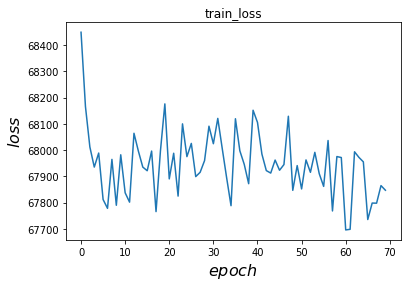

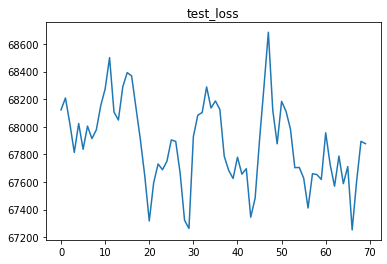

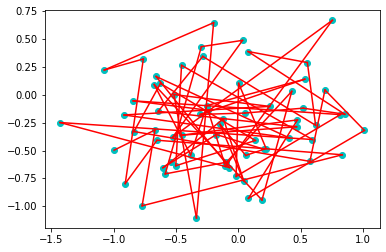

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.036134122290314444
      momentum: 0
      weight_decay: 0
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Test loss: nan


Setting status of trial#18 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (1,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__


Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  SGD (
  Parameter Group 0
      dampening: 0
      lr: 0.03477897878629297
      momentum: 0.9
      nesterov: False
      weight_decay: 2.1998006949176012e-06
  )


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch: 1 Train loss: nan


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Test loss: nan


Setting status of trial#19 as TrialState.FAIL because of the following error: ValueError('x and y must have same first dimension, but have shapes (70,) and (1,)')
Traceback (most recent call last):
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/optuna/study.py", line 468, in _run_trial
    result = func(trial)
  File "<ipython-input-251-23634b3ed3a8>", line 45, in objective
    plot_loss(epochs,history)
  File "<ipython-input-248-cbee7bc4af14>", line 7, in plot_loss
    plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2789, in plot
    is not None else {}), **kwargs)
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 225, in __call__


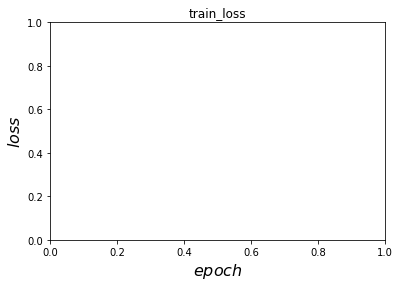

In [252]:
TRIAL_SIZE = 20
study = optuna.create_study()
error_rate=study.optimize(objective, n_trials=TRIAL_SIZE)

In [256]:
print(study.best_params)
study.best_value

{'generator_units': 86, 'optimizer': 'RMSprop', 'weight_decay': 7.911637399866299e-10, 'momentum_sgd_lr': 0.0003066020068133185}


64489.58075

In [254]:
# writer = SummaryWriter()

# history = {"train_loss":[],"test_loss":[]}

# for epoch in range(1, epochs + 1):
#     train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
#     test_loss = data_loop(epoch, test_loader, dmm, device)

#     writer.add_scalar('train_loss', train_loss, epoch)
#     writer.add_scalar('test_loss', test_loss, epoch)
    
#     history["train_loss"].append(train_loss)
#     history["test_loss"].append(test_loss)

#     sample = plot_image_from_latent(batch_size)[:, None][1,:]
#     writer.add_image('Image_from_latent', sample, epoch)

In [255]:
def inference_result(rnn,encoder)
inference_net = rnn*encoder
test_o = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
test_o = torch.tensor(test_o).reshape(1,len(test_o),20).to(device)
z_prev = torch.tensor(start_pos).to(device)
infered_result = inference_net.sample({"x":test_o,"z_prev":z_prev})["z"].to("cpu")
infered_result=infered_result.numpy()

plt.plot(infered_result[:,:, 0], infered_result[:,:, 1], "co")

for i in range(len(infered_result[0])-1):
    plt.plot([infered_result[0][i][0],infered_result[0][i+1][0]],[infered_result[0][i][1],infered_result[0][i+1][1]],"r")

plt.show()

SyntaxError: invalid syntax (<ipython-input-255-59a1ed3f812f>, line 1)